Ce notebook est composé de deux parties. Dans la première partie, je vais essayer de:
* Construire un CNN classifieur afin de classifier des images 
* Faire transfer Learning en utilisant un modèle déjà entrainé

Dans la deuxième partie:
* Je parlerai des réseaux GAN et nous allons apprendre la fonction sinus.

### Construction d'un Classifieur

#### Data
Vous pouvez retrouvées les données utilisées dans cette partie sur https://www.kaggle.com/puneet6060/intel-image-classification.


Nous avons environ 14K d'images pour entrainer nos modèles et 3K images pour les tester.

Les différentes classes sont:
* buildings -> 0,
* forest -> 1,
* glacier -> 2,
* mountain -> 3,
* sea -> 4,
* street -> 5

In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet34
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import random


manualSeed = 999


random.seed(manualSeed)
torch.manual_seed(manualSeed)


from collections import Counter


import os



import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set_style('whitegrid')


import numpy as np


from time import time


import altair as alt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:


transform ={
        'train': transforms.Compose(
                [transforms.Resize((150,150)),
                 transforms.ToTensor(),
                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                ]),
         'test':transforms.Compose([transforms.Resize((150,150)),                     
               transforms.ToTensor(),
               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])}


data_train=ImageFolder('./seg_train/seg_train/', transform=transform['train'])
data_test=ImageFolder('./seg_test/seg_test/', transform=transform['test'])



train_loader=DataLoader(data_train, batch_size=128,shuffle=True)

test_loader=DataLoader(data_test,batch_size=32)



classes=np.sort(os.listdir('./seg_train/seg_train/'))

J'ai utilisé la même transformation pour les données d'entrainement et de test (Normalisation et Standardisation).

Mais il est très courant de faire de la data augmentation (sur les données d'entrainement) afin d'augumenter la capacité de généralisation du modèle, prévenir le surapprentissage (overfitting).

On peut penser à des augmentations telles que le cropping, rotation etc ...

Vous pouvez trouvez ces augumentations ici https://pytorch.org/docs/stable/torchvision/transforms.html

In [3]:
cl=dict(Counter(data_train.targets))

print(f"la taille du jeu de données d'apprentissage: {len(data_train.targets)}")

la taille du jeu de données d'apprentissage: 14034


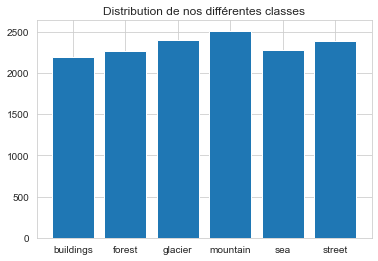

In [4]:
plt.bar(classes, cl.values());

plt.title('Distribution de nos différentes classes');

Les classes sont toutes bien représentées dans notre jeu d'apprentissage.


Regardons maintenant quelques images de notre ensemble d'apprentissage.

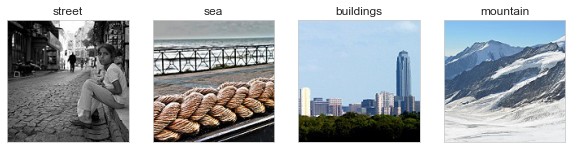

In [5]:
img,label=next(iter(train_loader))


mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]


unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],   #Pour mieux voir les images avec matplotlib
   std= [1/s for s in std])                    



def imshow(img):
    img=unnormalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(1,4,i+1)
    imshow(img[i])
    plt.title(classes[label[i]])
    plt.xticks([]), plt.yticks([])
    


A présent je vais construire un simple convolutional classifieur pour classer les images.

Le modèle est composé essentiellement de couches de convolutions et linéaires avec du MaxPooling(pour réduire la taille des features), j'utilise également du dropout pour prévenir un overfitting avec p=0.5.

In [6]:
class Classifieur(nn.Module):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),  
        nn.ReLU(), 
        nn.MaxPool2d(2,2), 
        nn.Dropout2d(0.5),    
        
        
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),   
        nn.ReLU(),  
        nn.MaxPool2d(2,2),  
        nn.Dropout2d(0.5),  
            
        
        nn.Flatten(),
        nn.Linear(in_features=16*34*34, out_features=120),
        nn.ReLU(),
        nn.Dropout(0.5),    
        
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Dropout(0.5) ,   
            
        nn.Linear(84,6),
           
        )
        
        
    def forward(self, x):
        return self.network(x)
    
  

La fonction ci_dessous va permettre d'entrainer le modèle. Le process est le suivant:
* Prédiction du modèle 
* Calcul du loss
* Calcul des gradients
* Mis à jour des poids

In [32]:
def train(model,optimizer,train_loader, test_loader, path):
    
    '''
    inputs:
    ----------------------------------------
    model: le modèle à entrainer
    train_loader: l'ensemble d'apprentissage
    test_loader: l'ensemble test
    lr:learning rate
    
    
    return:
    -----------------------------------------
    
    model: meilleur modèle en fonction de la valeur de l'accruracy sur le test
    accuracy_stats:l'évolution de l'accuracy sur les donnes apprentissage et test
    loss_stats: l'évolution du loss sur apprentissage et test
    
    
    '''

    accuracy_stats = {
        'train': [],
        "test": []
    }


    loss_stats = {
        'train': [],
        "test": []
    }




    best_accuracy=0
    epochs=5


    criterion=nn.CrossEntropyLoss()

    start=time()
    for epoch in range(epochs):

        train_epoch_loss=0
        train_epoch_accuracy=0
        total=0

        total_test=0


        for i,(inp,label) in enumerate(train_loader):
            output=model(inp)
            loss=criterion(output,label)

            optimizer.zero_grad() # on remet à zéro les gradients
            loss.backward() #Calcule le gradient
            optimizer.step() #mets à jour les poids et biais


            train_epoch_loss+=loss.item()  #Pour chaque epoch, je calcule le total du loss
            total+=label.size(0)
            _, predicted = torch.max(output.data, 1) #je prédis la classe
            train_epoch_accuracy+=(predicted == label).sum().item()

        train_epoch_loss/=total #Je prends la moyenne
        train_epoch_accuracy/=total
        loss_stats['train'].append(train_epoch_loss)
        accuracy_stats['train'].append(train_epoch_accuracy)   


        with torch.no_grad(): #Inutile d'accumuler le gradient pendant cette phase 

            model.eval()     #mode évaluation (certaines couches sont désactivées)

            test_epoch_loss=0
            test_epoch_accuracy=0


            for i,(inp,label) in enumerate(test_loader):

                output_test=model(inp)
                test_loss=criterion(output_test,label)

                test_epoch_loss+=test_loss.item()
                total_test+=label.size(0)
                _, predicted = torch.max(output_test.data, 1)
                test_epoch_accuracy+=(predicted == label).sum().item()

            test_epoch_loss/=total_test  
            test_epoch_accuracy/=total_test 
            loss_stats['test'].append(test_epoch_loss)
            accuracy_stats['test'].append(test_epoch_accuracy)


            if test_epoch_accuracy>best_accuracy:
                best_accuracy=test_epoch_accuracy
                torch.save(model.state_dict(), path) #enregistrer le meilleur modèle selon l'accuracy





            #if epoch % 5 == 0:
            print(f'epoch[{epoch+1}/{epochs}]\t train loss:{train_epoch_loss:.3f}\t test loss: {test_epoch_loss:.3f}')
    end=time()



    print(f'(time: {end-start}')
    
    
    model.load_state_dict(torch.load(path))
    
    
    return model, accuracy_stats, loss_stats
    

La fonction coût utilisée est le cross entropy https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

J'utilise un learning rate de 0.001 qui contrôle comment nos poids sont mis à jour. 

En plus des couches Dropout, j'utilise une régularisation weight decay de 0.005. Le weight decay ajoute une contrainte sur nos poids pour limiter les valeurs (L2 regularisation).


Pour avoir la bonne valeur pour ces hyperparamètres (y compris le batch size, le nombre d'epochs), j'ai testé empiriquement plusieurs valeurs et choisi celles qui semblent les mieux adaptées à mon problème. 



In [26]:
lr=0.001
model=Classifieur()
optimizer=torch.optim.Adam(model.parameters(),lr=lr, weight_decay=0.005)


best_model_Classifieur, accuracy_stats_Classifieur, loss_stats_Classifieur=\
            train(model=model,optimizer=optimizer,train_loader=train_loader, test_loader=test_loader,path='./classifieur.pth')

epoch[1/5]	 train loss:0.013	 test loss: 0.044
epoch[2/5]	 train loss:0.008	 test loss: 0.027
epoch[3/5]	 train loss:0.006	 test loss: 0.023
epoch[4/5]	 train loss:0.006	 test loss: 0.023
epoch[5/5]	 train loss:0.005	 test loss: 0.021
(time: 1767.812471151352


In [51]:
 #Le modèle enregistré correspond au modèle avec la plus grande valeur de l'accuracy
i=np.argmax(accuracy_stats_Classifieur['test'])


print(f"accuracy train: {accuracy_stats_Classifieur['train'][i]:.2f}")
print(f"accuracy test: {accuracy_stats_Classifieur['test'][i]:.2f}")

accuracy train: 0.77
accuracy test: 0.75


Avec 5 epochs, nous avons un accuracy de 0.75 sur les données test. 

In [28]:
# Je crée les dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats_Classifieur).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats_Classifieur).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

#je trace loss and accuracy pour train et test


char1=alt.Chart(train_val_acc_df).mark_line().encode(
            x=alt.X('epochs:O',scale=alt.Scale(zero=False)),
            y=alt.Y('value:Q',scale=alt.Scale(zero=False)),
            color='variable:N').properties(height=300,width=300,title='Accuracy')


char2=alt.Chart(train_val_loss_df).mark_line().encode(
            x='epochs:O',
            y='value:Q',
            color='variable:N').properties(height=300,width=300,title='Loss')

alt.hconcat(char1,char2).resolve_scale(y='independent')

alt.HConcatChart(...)

Avec plus de ressources, on peut augumenter le nombre d'epochs et regarder comment le modèle va se comporter.

Peut on faire mieux avec 5 epochs?

Je vais dans la section qui suit utiliser le transfert learning. Il s'agit d'agit d'adapter un modèle déjà entraîné sur nos données. 

Deux façons de faire le transfert:
* fine tuning: on apprend les données, à partir d'un modèle déjà entrainé
* features selection: on utilise un modèle entrainé en adaptant et en entrainant que la dernière couche (où les dernières couches)

Je vais utiliser la dernière option.

#### Features selection avec Resnet34

Pour tous détails sur le resnet, vous pouvez consulter l'article https://arxiv.org/abs/1512.03385.


J'utilise ce modèle déjà entrainé sur imagenet, je change la dernière couche pour l'adapter à mon probléme. Pendant la phase d'apprentissage, uniquement les poids de la dernière couche sont appris, les autres poids restent inchangés.

In [41]:
model = resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad=False   #On n'a pas besoin du gradient pour ces couches


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  #Le gradient est par défaut à True

In [42]:

optimizer=torch.optim.Adam(model.fc.parameters()) #Seuls les paramètres de la dernière couche sont mis à jour



best_model, accuracy_stats_resnet, loss_stats_resnet=\
        train(model=model, optimizer=optimizer,train_loader=train_loader, test_loader=test_loader,path='./classifieur2.pth')

epoch[1/5]	 train loss:0.006	 test loss: 0.013
epoch[2/5]	 train loss:0.003	 test loss: 0.011
epoch[3/5]	 train loss:0.003	 test loss: 0.010
epoch[4/5]	 train loss:0.002	 test loss: 0.010
epoch[5/5]	 train loss:0.002	 test loss: 0.010
(time: 6335.893872022629


In [50]:
i=np.argmax(accuracy_stats_resnet['test'])


print(f"accuracy train best model resnet: {accuracy_stats_resnet['train'][i]:.2f}")
print(f"accuracy test best model resnet: {accuracy_stats_resnet['test'][i]:.2f}")

accuracy train best model resnet: 0.90
accuracy test best model resnet: 0.89


En faisant du transfert learning, nous avons très nettement amélioré notre modèle de 0.75 à 0.89.

In [44]:
# Je crée les dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats_resnet).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats_resnet).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

#je trace loss and accuracy pour train et test


char1=alt.Chart(train_val_acc_df).mark_line().encode(
            x=alt.X('epochs:O',scale=alt.Scale(zero=False)),
            y=alt.Y('value:Q',scale=alt.Scale(zero=False)),
            color='variable:N').properties(height=300,width=300,title='Accuracy')


char2=alt.Chart(train_val_loss_df).mark_line().encode(
            x='epochs:O',
            y='value:Q',
            color='variable:N').properties(height=300,width=300,title='Loss')

alt.hconcat(char1,char2).resolve_scale(y='independent')

alt.HConcatChart(...)

On peut voir que l'accuracy test ne s'éloigne pas trop de l'accuracy train (pas d'overfitting).

In [45]:
def get_prediction(model,data_loader):
    
    prediction=[]
    lab=[]
    with torch.no_grad():
        model.eval()
        for data in data_loader:
            inp, labels = data
            outputs = model(inp)
            _, predicted = torch.max(outputs.data, 1)

            prediction.extend(predicted.squeeze().tolist())
            lab.extend(labels.squeeze().tolist())
    return prediction,lab

In [46]:
prediction,label=get_prediction(best_model,test_loader)

In [47]:
from sklearn.metrics import classification_report,confusion_matrix


print(classification_report(label,prediction,zero_division=0,target_names=classes))

              precision    recall  f1-score   support

   buildings       0.91      0.88      0.90       437
      forest       0.99      0.98      0.99       474
     glacier       0.89      0.79      0.84       553
    mountain       0.81      0.85      0.83       525
         sea       0.88      0.95      0.91       510
      street       0.90      0.93      0.91       501

    accuracy                           0.89      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.89      0.89      0.89      3000



On peut voir que le f1 score est bas (en fonction des autres f1) pour les mountains et les gaciers.

In [48]:
idx2Class={v:classes[v] for v in range(6)}


df_confusion=pd.DataFrame(confusion_matrix(label,prediction)).rename(columns=idx2Class,index=idx2Class)


conf=df_confusion.reset_index().melt('index')
conf.columns=['True value','prediction','number']
b=alt.Chart(conf).encode(
            x='prediction:N',
            y='True value:N'
    ).properties(height=400,width=400)

rec=b.mark_rect().encode(
            color='number'
        )
text=b.mark_text().encode(
        text=alt.Text('number')
)

rec+text

alt.LayerChart(...)

Le modèle semble parfois avoir du mal à distinguer un glacier d'un mountain et vice versa.

### Conclusion

Lorsqu'on s'attaque à ce type de problème, on a souvent un problème d'overfitting mais le Dropout ou la régularisation L2 permet de le contourner.

Le transfert Learning permet d'avoir un accuracy très grand avec peu d'épochs.

### GAN 1D

In [52]:
import matplotlib.pyplot as plt

import torch
import numpy as np 


from torch.utils.data import  TensorDataset

C'est quoi un GAN? Avant de répondre à cette question, je fais un petit détour pour parler des modèles discriminatifs et génératifs.

Un modèle génératif est un modèle qui apprend la distribution jointe $P(X,Y)$ avec X, Y deux variables aléatoires et par la formule de Bayes va estimer la probabilté $P(Y|X)$. Pour rappel la formule de Bayes s'écrit: $$P(Y|X)=\frac {P(X|Y) P(Y)}{P(X)}$$ où 

* $P(Y|X)$ est appelé probabilité a posteriori (statistiques bayésiennes)
* $P(Y)$ est la probabilité à priori (statistiques bayésiennes)

On peut penser au GMM (Gaussian Mixture  Model), le classifieur Naive Bayes, les chaînes de Markov cachés etc...


tandis qu'un modèle discriminatif va apprendre directement la probabilité conditionnelle $P(Y|X)$ à partir des données.On peut penser au SVM, au réseau de neurones simples définis tout à l'heure (par exemple), la régression logistique etc... 

GAN (Generative Adversarial Network), est un modèle génératif qui a été proposé par Ian J. Goodfellow et son équipe en 2014.https://arxiv.org/abs/1406.2661
Il s'agit de deux modèles en compétition le discriminateur D et le générateur G.


* le but du générateur dans la phase d'apprentissage est de maximiser la probabilité que le discriminateur se trompe en générant des exemples (fake) ressemblant de plus en plus aux données d'apprentissage.
* le but du discrimininateur est de maximiser la probabilité de bien classifier les fake et les true


Formellement nous allons maximiser pour le discriminateur $log(D(x))+log(1-D(G(z))$ où z est la variable latente ou le noise.

Pour le générateur nous allons minimiser $log(1-D(G(z))$, en pratique on maximise (voir le papier) log(D(G(z)).


Je vais essayer d'apprendre la fonction sinus dans l'intervalle $[0,2\pi]$.

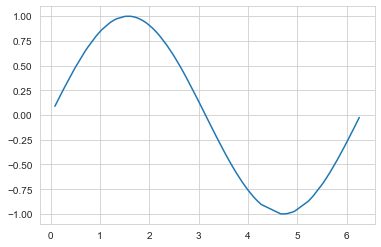

In [53]:
X=np.sort(2*np.pi*np.random.rand(100))

plt.plot(X, np.sin(X)); 

In [54]:

def generate_sample(n):
    '''
    génére un échantillon (x,sin(x))
    '''
    X=2*np.pi*np.random.rand(n).reshape(n,1)
    return np.hstack((X,np.sin(X)))



In [55]:
batch_size=32
dataset_train=generate_sample(1024)

train_loader=DataLoader(dataset_train,batch_size=batch_size) #crée un itérateur

Mon discriminateur est composé de couches linéaires, relu et dropout et une couche de sortie sigmoid.

Le générateur est composé de couches linéaires et relu. La fonction coût utilisé est le Binary Cross Entropy Loss https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html, avec comme algorithme d'optmisation Adam.

Entraîner un modèle GAN (images, vidéos notamment) peut être très complexe, problème de convergence, cependant il existe certaines heuristiques vous pouvez consulter:
https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/

https://github.com/soumith/ganhacks

Je me suis également beaucoup inspiré de https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html.


In [56]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        
        return self.network(x)
    
        
        
        
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        return self.network(x)

     

In [57]:
discriminator=Discriminator()   
generator = Generator() 


lr=0.001
num_epochs=1000
criterion=nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)






G_losses = []
D_losses = []


print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader,0):
        
        #Entrainement du discriminateur sur les vraies données
        discriminator.zero_grad() #zero grad
        label=torch.full((batch_size,1),1).float() #true label==1
    
        output=discriminator(data.float()) 
        errD_on_real=criterion(output,label)  #log(D(x))
        
        errD_on_real.backward() #on calcule le gradient pour les réels
        
        D_x = output.mean().item()

        #Entrainement du discriminateur sur les fakes
        z = torch.randn((batch_size, 2))  #variable latente
        fake = generator(z)
        
        
        output = discriminator(fake.detach())
        label.fill_(0)
        errD_on_fake = criterion(output, label) #log(1-D(G(z)))
        
        errD_on_fake.backward()
        
        errD = errD_on_real + errD_on_fake  #log(D(x)+log(1-D(G(z))))
        
        optimizer_discriminator.step()
        
        D_G_z1 = output.mean().item()
        
    
        # Entrainement du générateur
        generator.zero_grad()
        
        label.fill_(1)
        
        output = discriminator(fake)
        errG = criterion(output, label)  #log(D(G(z)))
        
        errG.backward()
        
        
        optimizer_generator.step()
        
        D_G_z2 = output.mean().item()
        
    if epoch % 100 == 0:
            print(f"Epoch: {epoch} \tLoss D.: {errD:.2f}\t Loss G.: {errG:.2f}\t D(x): {D_x:.2f}\t D(G(z)): {D_G_z1:.2f}/{D_G_z2:.2f} ")
    
    G_losses.append(errG.item())
    D_losses.append(errD.item())
 
        
   

Starting Training Loop...
Epoch: 0 	Loss D.: 0.25	 Loss G.: 2.57	 D(x): 0.94	 D(G(z)): 0.09/0.09 
Epoch: 100 	Loss D.: 1.40	 Loss G.: 0.95	 D(x): 0.44	 D(G(z)): 0.41/0.41 
Epoch: 200 	Loss D.: 1.41	 Loss G.: 0.88	 D(x): 0.51	 D(G(z)): 0.51/0.44 
Epoch: 300 	Loss D.: 1.42	 Loss G.: 0.77	 D(x): 0.51	 D(G(z)): 0.51/0.49 
Epoch: 400 	Loss D.: 1.18	 Loss G.: 1.01	 D(x): 0.58	 D(G(z)): 0.44/0.42 
Epoch: 500 	Loss D.: 1.09	 Loss G.: 1.14	 D(x): 0.57	 D(G(z)): 0.38/0.39 
Epoch: 600 	Loss D.: 1.29	 Loss G.: 0.80	 D(x): 0.56	 D(G(z)): 0.49/0.48 
Epoch: 700 	Loss D.: 1.39	 Loss G.: 0.69	 D(x): 0.51	 D(G(z)): 0.50/0.51 
Epoch: 800 	Loss D.: 1.37	 Loss G.: 0.72	 D(x): 0.51	 D(G(z)): 0.49/0.49 
Epoch: 900 	Loss D.: 1.39	 Loss G.: 0.71	 D(x): 0.51	 D(G(z)): 0.50/0.50 


D(x) doit commencer vers environ 1 et converger théoriquement vers 0.5 (au début le générateur ne produit pas de bons exemples et donc le discriminateur se trompe moins).

D(G(z)) commence lui par 0  et commence à converger vers 0.5.

* D(x) qui représente la moyenne des estimations des probabilités que les exemples viennent de l'ensemble d'apprentissage
* D(G(z)) représente la moyenne des estimations des probabilités que les exemples viennent du générateur.


On peut voir sur ces statistiques que notre modèle converge vers cet équilibre théorique $D(x)\approx D(G(z))\approx 0.5$.

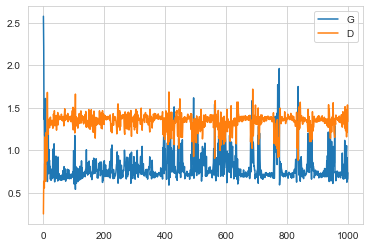

In [58]:
plt.plot(G_losses,label='G')
plt.plot(D_losses,label='D')
plt.legend();

Dans la figure ci_dessus j'ai tracé l'évolution des loss pour le discriminateur et générateur.

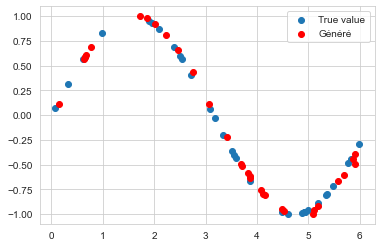

In [59]:
plt.scatter(data[:,0],data[:,1],label='True value')
plt.scatter(fake.detach().numpy()[:,0],fake.detach().numpy()[:,1],c='r',label='Généré')
plt.legend();

### Conclusion
D'après cette expérience, on peut voir que les GAN sont très performants pour apprendre des distributions de probabilité. Prochaines étapes:
* Utiliser les GAN pour générer des images 
* Utiliser les GAN pour faire du semi supervisé learning

Vous pouvez également consulter https://deepmind.com/blog/article/wavenet-generative-model-raw-audio pour observer la magie de ces modèles.